In [1]:
# Caminhos para a pasta de dados
import os 

# Pasta atual
pastaAtual = os.getcwd()
print(pastaAtual)

# Pasta de dados
pastaDados = r'C:\Users\rafael.shibayama\Documents\GitHub\ENS410064\2024\Dados\atividade4_'
listaDados = os.listdir(pastaDados)

# Listando arquivos
print(listaDados)

# Selecionando arquivos do MERRA2
prefixed = [filename for filename in os.listdir(pastaDados) if filename.startswith("MERRA2")]
print(prefixed)

C:\Users\rafael.shibayama\Documents\GitHub\ENS410064\2024\Notebooks
['BR_Pais_2022', 'MERRA2_400.inst3_3d_chm_Nv.20230101.nc4']
['MERRA2_400.inst3_3d_chm_Nv.20230101.nc4']


In [31]:
import xarray as xr

# Pasta de dados
pastaDados = r'C:\Users\rafael.shibayama\Documents\GitHub\ENS410064\2024\Dados\atividade4_'
listaDados = os.listdir(pastaDados)

# Listar variáveis disponíveis
print(dataset.variables)

# Visualizar informações gerais
print(dataset)

Frozen({'lon': <xarray.IndexVariable 'lon' (lon: 576)> Size: 5kB
array([-180.   , -179.375, -178.75 , ...,  178.125,  178.75 ,  179.375])
Attributes:
    long_name:    longitude
    units:        degrees_east
    vmax:         1000000000000000.0
    vmin:         -1000000000000000.0
    valid_range:  [-1.e+15  1.e+15], 'lat': <xarray.IndexVariable 'lat' (lat: 361)> Size: 3kB
array([-90. , -89.5, -89. , ...,  89. ,  89.5,  90. ])
Attributes:
    long_name:    latitude
    units:        degrees_north
    vmax:         1000000000000000.0
    vmin:         -1000000000000000.0
    valid_range:  [-1.e+15  1.e+15], 'lev': <xarray.IndexVariable 'lev' (lev: 72)> Size: 576B
array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59

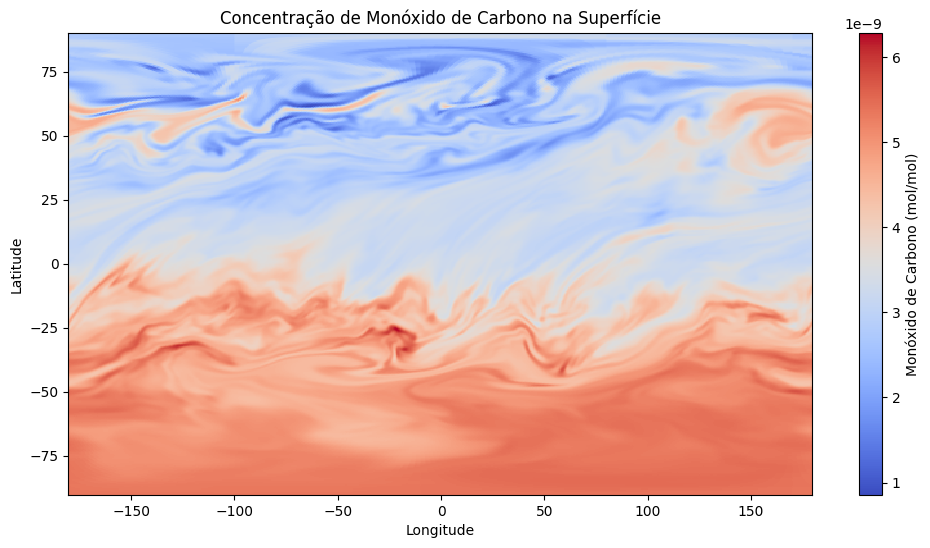

In [9]:
# Plotando o dado 1D 
import matplotlib.pyplot as plt

# Selecionar CO no nível mais próximo da superfície
co_surface = dataset["CO"].isel(time=0, lev=0)

# Operações com o numpy
import numpy as np
import geopandas as gpd
import matplotlib

br = gpd.read_file(r"C:\Users\rafael.shibayama\Documents\GitHub\ENS410064\2024\Dados\atividade4_\BR_Pais_2022")

# Criar o gráfico
plt.figure(figsize=(12, 6))
co_surface.plot(
    cmap="coolwarm",
    cbar_kwargs={"label": "Monóxido de Carbono (mol/mol)"},
)
plt.title("Concentração de Monóxido de Carbono na Superfície")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


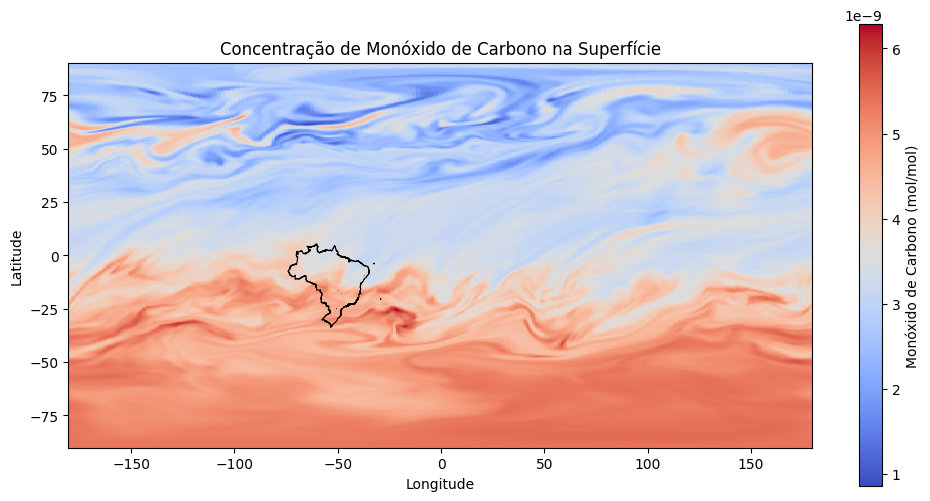

In [10]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

# Abrir o shapefile do Brasil
shapefile_path = r"C:\Users\rafael.shibayama\Documents\GitHub\ENS410064\2024\Dados\atividade4_\BR_Pais_2022"
brasil = gpd.read_file(shapefile_path)

# Selecionar CO no nível mais próximo da superfície
co_surface = dataset["CO"].isel(time=0, lev=0)

# Criar o gráfico
plt.figure(figsize=(12, 6))

# Plotar os dados de monóxido de carbono
co_surface.plot(
    cmap="coolwarm",
    cbar_kwargs={"label": "Monóxido de Carbono (mol/mol)"},
)

# Sobrepor o shapefile do Brasil
brasil.boundary.plot(ax=plt.gca(), color="black", linewidth=0.8)

# Adicionar título e rótulos
plt.title("Concentração de Monóxido de Carbono na Superfície")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [27]:
import xarray as xr
import rioxarray
import geopandas as gpd
from shapely.geometry import mapping

# Carregar o dataset NetCDF
arquivo_nc = r"C:\Users\rafael.shibayama\Documents\GitHub\ENS410064\2024\Dados\atividade4_\MERRA2_400.inst3_3d_chm_Nv.20230101.nc4"
xds = xr.open_dataset(arquivo_nc)

# Extrair os dados de CO no tempo inicial e nível mais próximo da superfície
co = xds["CO"].isel(time=0, lev=0)

# Carregar o shapefile do Brasil
shapefile_path = r"C:\Users\rafael.shibayama\Documents\GitHub\ENS410064\2024\Dados\atividade4_\BR_Pais_2022"
br = gpd.read_file(shapefile_path)

# Criar o DataArray com coordenadas geográficas
da0 = xr.DataArray(
    data=co.values,
    dims=["y", "x"],
    coords=dict(
        x=(["x"], xds["lon"].values),
        y=(["y"], xds["lat"].values),
    ),
    attrs={
        "units": "mol/mol",
        "description": "Monóxido de Carbono recortado pelo Brasil"
    },
)

# Atribuir o CRS ao DataArray
da = da0.rio.write_crs("EPSG:4326", inplace=True)

# Verificar e ajustar o CRS do shapefile
if br.crs != "EPSG:4326":
    br = br.to_crs("EPSG:4326")

# Realizar o recorte do DataArray com o shapefile
geodf = br.copy()
clipped = da.rio.clip(geodf.geometry.apply(mapping), geodf.crs, drop=False)

# Salvar o resultado como NetCDF
output_file = "ClipBR.nc"
clipped.to_netcdf(output_file)

print(f"Recorte realizado com sucesso. Dados salvos em '{output_file}'.")


Recorte realizado com sucesso. Dados salvos em 'ClipBR.nc'.


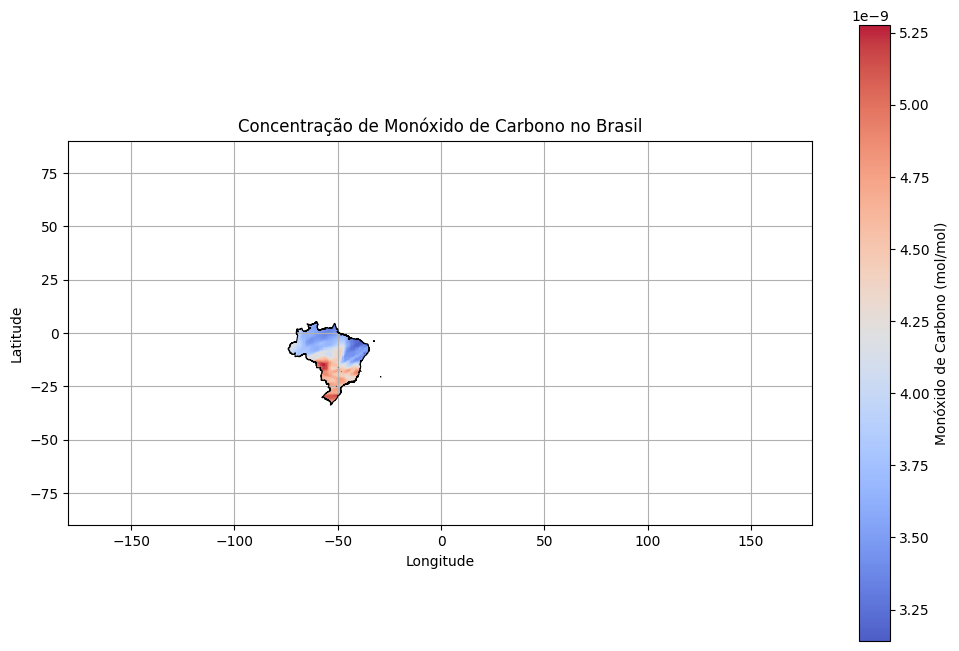

In [28]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

# Carregar o arquivo NetCDF recortado
arquivo_recorte = "ClipBR.nc"
recorte = xr.open_dataset(arquivo_recorte)

# Selecionar a variável de monóxido de carbono
co_brasil = recorte["__xarray_dataarray_variable__"]  # Substitua pelo nome correto se diferente

# Carregar o shapefile do Brasil para sobreposição
shapefile_path = r"C:\Users\rafael.shibayama\Documents\GitHub\ENS410064\2024\Dados\atividade4_\BR_Pais_2022"
brasil = gpd.read_file(shapefile_path)

# Configurar o mapa
plt.figure(figsize=(12, 8))
ax = plt.gca()

# Plotar o dado recortado
co_brasil.plot(
    ax=ax,
    cmap="coolwarm",
    cbar_kwargs={"label": "Monóxido de Carbono (mol/mol)"},  # Legenda
    alpha=0.9,  # Transparência para visualização mais clara
)

# Plotar o contorno do Brasil
brasil.boundary.plot(ax=ax, color="black", linewidth=0.8)

# Configurações adicionais do mapa
plt.title("Concentração de Monóxido de Carbono no Brasil")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()


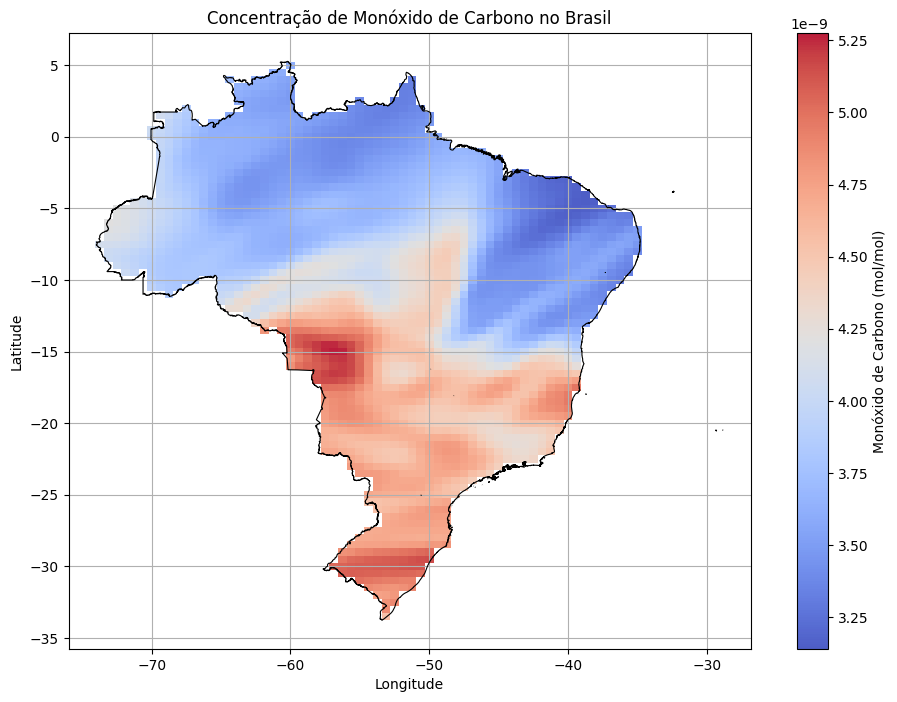

In [29]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

# Carregar o arquivo NetCDF recortado
arquivo_recorte = "ClipBR.nc"
recorte = xr.open_dataset(arquivo_recorte)

# Selecionar a variável de monóxido de carbono
co_brasil = recorte["__xarray_dataarray_variable__"]  # Substitua pelo nome correto se necessário

# Carregar o shapefile do Brasil para sobreposição
shapefile_path = r"C:\Users\rafael.shibayama\Documents\GitHub\ENS410064\2024\Dados\atividade4_\BR_Pais_2022"
brasil = gpd.read_file(shapefile_path)

# Obter os limites do shapefile para definir o zoom
minx, miny, maxx, maxy = brasil.total_bounds

# Configurar o mapa
plt.figure(figsize=(12, 8))
ax = plt.gca()

# Plotar os dados recortados
co_brasil.plot(
    ax=ax,
    cmap="coolwarm",
    cbar_kwargs={"label": "Monóxido de Carbono (mol/mol)"},  # Legenda
    alpha=0.9,  # Transparência
)

# Plotar o contorno do Brasil
brasil.boundary.plot(ax=ax, color="black", linewidth=0.8)

# Ajustar os limites para focar no Brasil
ax.set_xlim(minx - 2, maxx + 2)  # Adiciona um pequeno buffer ao redor
ax.set_ylim(miny - 2, maxy + 2)

# Configurações adicionais do mapa
plt.title("Concentração de Monóxido de Carbono no Brasil")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()


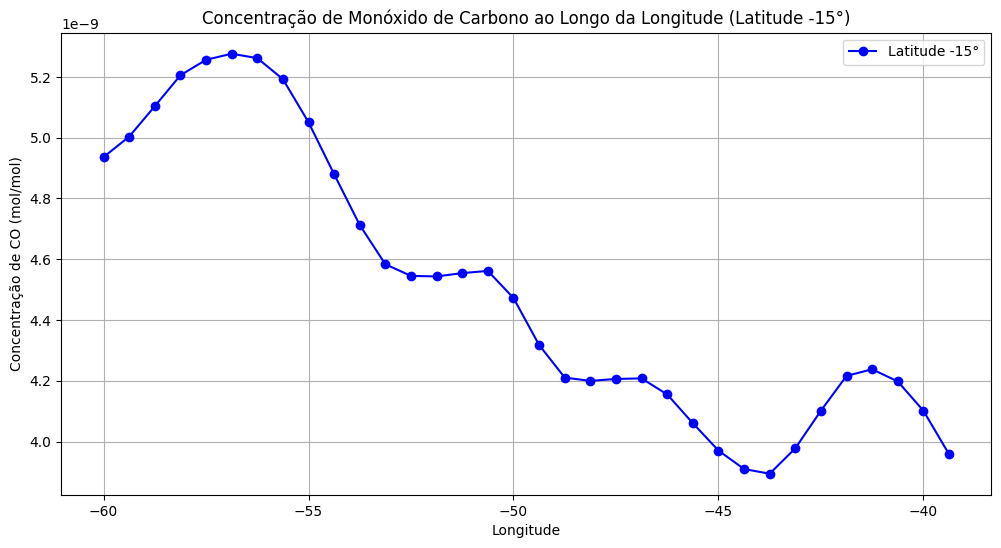

In [30]:
import xarray as xr
import matplotlib.pyplot as plt

# Carregar o arquivo NetCDF recortado
arquivo_recorte = "ClipBR.nc"
recorte = xr.open_dataset(arquivo_recorte)

# Selecionar a variável de monóxido de carbono
co_brasil = recorte["__xarray_dataarray_variable__"]  # Substitua pelo nome correto se necessário

# Selecionar os dados na latitude mais próxima de -15
co_lat_15 = co_brasil.sel(y=-15, method="nearest")

# Plotar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(co_lat_15["x"], co_lat_15.values, marker="o", color="blue", label="Latitude -15°")

# Adicionar título e rótulos
plt.title("Concentração de Monóxido de Carbono ao Longo da Longitude (Latitude -15°)")
plt.xlabel("Longitude")
plt.ylabel("Concentração de CO (mol/mol)")
plt.grid()
plt.legend()
plt.show()
